# DEMO

### Import des librairies et classes nécessaires

In [64]:
from mnist_config import ConfigDict
from mnist_network import MNISTNetwork
from data_provider import MNISTDataset
from text_network import TextLargeMarginModel
import random
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


In [65]:
BATCH_SIZE = 256
EXPERIMENT_TYPE = "mnist"
DATA_DIR = "./mnist"

### Chargement des modèles

In [66]:
model_path_0_lm = "./models/lm_20epochs_model.keras"
model_path_0_xent = "./models/xent_20epochs_model.keras"
model_path_1 = "./models/xent_100epochs_lr0_05_noisy_model.keras"
model_path_2 = "./models/lm_100epochs_lr0_05_noisy_model.keras"
model_path_3 = "./models/xent_100epochs_lr0_01_generalization_batch8_model.keras"
model_path_4 = "./models/lm_100epochs_lr0_01_generalization_batch8_model.keras"
model_path_5 = "./models/text_model_xent_V2_adam.keras"
model_path_6 = "./models/text_model_lm_gamma01_lr0001_adam.keras"
model_path_7 = "./models/text_model_xent_lm_adam.keras"

model_0_lm = load_model(
    model_path_0_lm,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_0_xent = load_model(
    model_path_0_xent,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_1 = load_model(
    model_path_1,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_2 = load_model(
    model_path_2,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_3 = load_model(
    model_path_3,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_4 = load_model(
    model_path_4,
    compile=False,
    custom_objects={"MNISTNetwork": MNISTNetwork})
model_5 = load_model(
    model_path_5,
    compile=False,
    custom_objects={"TextLargeMarginModel": TextLargeMarginModel})
model_6 = load_model(
    model_path_6,
    compile=False,
    custom_objects={"TextLargeMarginModel": TextLargeMarginModel})
model_7 = load_model(
    model_path_7,
    compile=False,
    custom_objects={"TextLargeMarginModel": TextLargeMarginModel})

model_list_images = [model_0_lm, model_0_xent, model_1, model_2, model_3, model_4]
model_names_images = ["model_0_lm", "model_0_xent", "model_1", "model_2", "model_3", "model_4"]

model_list_texts = [model_5, model_6, model_7]
model_names_texts = ["model_5", "model_6", "model_7"]

### Récupération du dataset de test MNIST

In [67]:
val_dataset_wrapper = MNISTDataset(
    data_dir=DATA_DIR,
    subset="test",   # "test" : validation | "train" : training | "noisy" : noisy training
    batch_size=BATCH_SIZE,
    is_training=False
)

val_dataset = val_dataset_wrapper.dataset
num_examples = val_dataset_wrapper.num_examples
num_classes = val_dataset_wrapper.num_classes

### Résultats de la classification d'image

In [68]:

for model in model_list_images:
    margin_losses = []
    accuracies = []
    config = ConfigDict()

    for images, labels in val_dataset:
        logits, endpoints = model(images, training=False)

        layers_list = [images]
        for i in range(len(config.filter_sizes_conv_layers)):
            layers_list.append(endpoints[f"conv_layer{i}"])

        one_hot_labels = tf.one_hot(labels, num_classes)

        acc = tf.reduce_mean(tf.cast(tf.argmax(logits, axis=1) == tf.cast(labels, tf.int64), tf.float32))
        accuracies.append(acc.numpy())

    print(f"Validation Accuracy  {model_names_images[model_list_images.index(model)]}:", np.mean(accuracies))

Validation Accuracy  model_0_lm: 0.99433595
Validation Accuracy  model_0_xent: 0.9933594
Validation Accuracy  model_1: 0.5001953
Validation Accuracy  model_2: 0.8623047
Validation Accuracy  model_3: 0.76826173
Validation Accuracy  model_4: 0.7555664


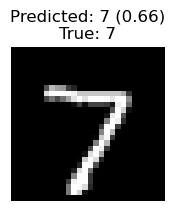

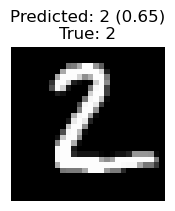

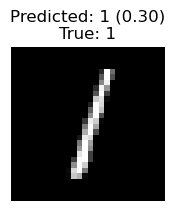

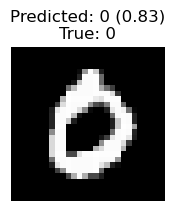

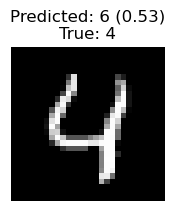

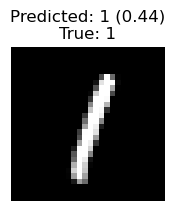

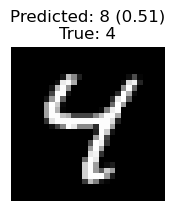

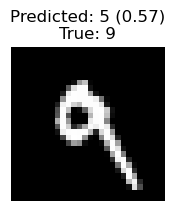

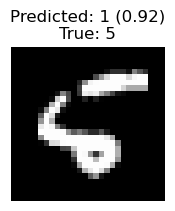

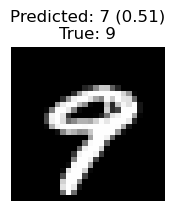

In [ ]:
test_model = model_1 # choose the model to visualize predictions in [model_0_lm, model_0_xent, model_1, model_2, model_3, model_4]

for images, labels in val_dataset.take(1):
    
    # Prediction
    logits, endpoints = test_model(images, training=False)
    
    # Get predicted label in a readable form
    probs = tf.nn.softmax(logits)
    predicted_classes = tf.argmax(probs, axis=1)

    # 10 first images of the batch
    for k in range(10):
        ex_image = images[k]
        pred_label = predicted_classes[k].numpy() # predicted label
        true_label = labels[k].numpy()            # true label
        confidence = np.max(probs[k].numpy())     # probability = confidence

        plt.figure(figsize=(2,2))
        
        if ex_image.shape[-1] == 1:
            plt.imshow(ex_image.numpy().reshape(28, 28), cmap='gray')
        else:
            plt.imshow(ex_image.numpy())
            
        plt.title(f"Predicted: {pred_label} ({confidence:.2f})\nTrue: {true_label}")
        plt.axis('off')
        plt.show()

Il est intéressant de noter que les différents modèles ne font pas les mêmes erreurs : il ne sont pas sensibles aux mêmes difficultés pour la prédiction. Pour le modèle 1 (entropie croisée) par exemple, qui prédit un 1 à la place d'un 5 avec une forte confiance, cela est du au fait qu'il a appris sur un dataset avec une mauvaise labellisation et a donc sur-appris des exemples faux. Au contraire le modèle 2 (large marge) entraîné sur le même dataset, il a beaucoup moins appris ces "détails" grâce à la marge et lorsqu'il prédit des erreurs, c'est avec une confiance faible et donc des images ambigues : on pourrait modifier les paramètres de la marge pour rendre le modèle encore plus robuste à ce genre d'erreurs.  

Il s'agit en fait d'une propriété de la marge qui va globalement faire des prédictions avec moins de confiance que le modèle avec entropie croisée. Le modèle à entropie croisé est poussé à faire ses prédictions avec une confiance maximale. Au contraire, le modèle à large marge considèrera une prédiction comme juste à partir du moment ou le point est à une distance satisfaisante de la frontière de décision : il ne va pas chercher à avoir un distance maximale pour une confiance maximale, il se contente d'un écart suffisant définis par les paramètres de la marge dans le modèle.

### Récupération du dataset de test IMDB

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000
NUM_CLASSES = 2
def get_imdb_data():
    print("Chargement IMDB...")
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
    
    # padding = cut large sequences
    x_train = pad_sequences(x_train, maxlen=200, padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=200, padding='post', truncating='post')
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(BATCH_SIZE)
    return train_ds, test_ds

dataset, test_dataset = get_imdb_data()

Chargement IMDB...


### Résultats de la classification de texte

In [45]:
for model in model_list_texts:
    margin_losses = []
    accuracies = []
    config = ConfigDict()

    for x_batch, labels in test_dataset:
        logits, layers_list = model(x_batch) 

        num_classes = NUM_CLASSES

        one_hot_labels = tf.one_hot(labels, num_classes)

        acc = tf.reduce_mean(tf.cast(tf.argmax(logits, axis=1) == tf.cast(labels, tf.int64), tf.float32))
        accuracies.append(acc.numpy())

    print(f"Validation Accuracy  {model_names_texts[model_list_texts.index(model)]}:", np.mean(accuracies))

Validation Accuracy  model_5: 0.84204
Validation Accuracy  model_6: 0.83052
Validation Accuracy  model_7: 0.84164


In [84]:
import numpy as np

word_index = imdb.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

# decoding function for imdb reviews
def decode_review(text_ids):
    text_ids_flat = np.array(text_ids).flatten()
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_ids_flat])

In [ ]:
for x_batch, y_batch in test_dataset.take(1):
    logits, _ = model_6(x_batch, training=False)
    probs = tf.nn.softmax(logits)
    predicted_classes = tf.argmax(probs, axis=1)

    # 3 first critics
    for k in range(8): # careful : can't exceed batch size
        raw_ids = x_batch[k].numpy()
        review_text = decode_review(raw_ids)
        
        true_label = "Positif" if y_batch[k] == 1 else "Négatif"
        pred_label = "Positif" if predicted_classes[k] == 1 else "Négatif"
        confidence = np.max(probs[k].numpy())

        print(f"\n--- Critique n°{k} ---")
        print(f"Vrai: {true_label} | Prédit: {pred_label} ({confidence:.2%})")
        print(f"Texte: {review_text}...")


--- Critique n°0 ---
Vrai: Positif | Prédit: Positif (59.48%)
Texte: ? this film is one of the best memories i have from childhood having always loved ? my mum took me to see it br br it is absolutely amazing its is one of those films that leaves a lasting impression on you the image of ? running through the snow with it all ? around is still in my head some 25 ? on not many films have managed that as other comments have said photography is stunning a must see i have also been looking for the film for some time with no luck at all checking amazon every now and then reveals nothing not even listed if anyone does know of a source please contact me or post here tim ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?...

--- Critique n°1 ---
Vrai: Négatif | Prédit: Négatif (61.64%)
Texte: ? it's hard to make a negative statement here after all this raving about how great deed ? is how won

On remarque encore que le modèle à large marge prédit non seulement les erreurs mais aussi les bonnes prédictions avec moins de confiance que le modèle avec entropie croisée. Cela est encore du à la propriété de la marge qui considère une prédiction bonne à partir du moment où elle est à assez bonne distance de la frontière de décision.